# Basic Data Manipulation

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
# Importing the training data
train = pd.read_csv('data/train.csv', parse_dates=['first_day_of_month'])
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [163]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [164]:
# Removing row_id, county, and state because those are redundant columns
train.drop(['row_id', 'county', 'state'], axis=1, inplace=True)

In [165]:
train.head()

,cfips,first_day_of_month,microbusiness_density,active
0,1001,2019-08-01,3.007682,1249
1,1001,2019-09-01,2.884870,1198
2,1001,2019-10-01,3.055843,1269
3,1001,2019-11-01,2.993233,1243
4,1001,2019-12-01,2.993233,1243


In [166]:
# Separating day, month, and year into their own features
train['year'] = train['first_day_of_month'].dt.year
train['month'] = train['first_day_of_month'].dt.month
train['day'] = train['first_day_of_month'].dt.day
train.drop('first_day_of_month', axis=1, inplace=True)

In [167]:
train.head()

,cfips,microbusiness_density,active,year,month,day
0,1001,3.007682,1249,2019,8,1
1,1001,2.884870,1198,2019,9,1
2,1001,3.055843,1269,2019,10,1
3,1001,2.993233,1243,2019,11,1
4,1001,2.993233,1243,2019,12,1


In [168]:
np.unique(train['day'])

array([1], dtype=int64)

In [169]:
# Since the day column has only one value, we can remove that as well
train.drop('day', axis=1, inplace=True)

In [170]:
# Dropping the active column because that's not in the test dataset
train.drop('active', axis=1, inplace=True)

In [171]:
train.head()

,cfips,microbusiness_density,year,month
0,1001,3.007682,2019,8
1,1001,2.884870,2019,9
2,1001,3.055843,2019,10
3,1001,2.993233,2019,11
4,1001,2.993233,2019,12


Since we want to build a forecasting model, we cannot just merely split the data into a training and testing set randomly. Instead, to evaluate a model on its forecasting ability, we need to train it on the first 80% of the dates and test it on the last 20% of the dates that are in our training set (for each `cfips` id)

In [172]:
from sklearn.model_selection import train_test_split

training_set = train[train['year'] < 2022].append(train[(train['year'] == 2022) & (train['month'] <= 2)])
X_train = training_set.drop('microbusiness_density', axis=1)
y_train = training_set['microbusiness_density']

# Resetting index
X_train.index = np.arange(len(X_train))
y_train.index = np.arange(len(y_train))

validation_set = train[(train['year'] == 2022) & (train['month'] > 2)]
X_val = validation_set.drop('microbusiness_density', axis=1)
y_val =validation_set['microbusiness_density']

# Resetting index
X_val.index = np.arange(len(X_val))
y_val.index = np.arange(len(y_val))

# Training

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [174]:
# This will make training/evaluating much simpler

# Contains the name of the model as a string
# Contains a list with the first index as the model and the second index as the color it should be represented with
model_dict = {'LinearRegression': LinearRegression(),
              'RandomForestRegressor': RandomForestRegressor(), 
              'XGBoostRegressor': xgb.XGBRegressor()}

In [175]:
def training(model_dict, X_train, y_train):
  '''
  Trains all the models in `model_dict` on `X_train` and `y_train` and returns
  a dictionary of trained models and the model's names.
  '''
  
  # Training models and documenting when they're training
  for model_name, model_list in model_dict.items():
    print(f'Training {model_name}...')
    model_list.fit(X_train, y_train)
  
  return model_dict

In [176]:
trained_model_dict = training(model_dict, X_train, y_train)

Training LinearRegression...
Training RandomForestRegressor...
Training XGBoostRegressor...


In [177]:
trained_model_dict

{'LinearRegression': LinearRegression(),
 'RandomForestRegressor': RandomForestRegressor(),
 'XGBoostRegressor': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)}

# Evaluation for Basic Models

$$SMAPE = \frac{1}{n} * \sum^{n}_{i=1}{\frac{2 * |P_i - A_i|}{(|A_i| + |P_i|)}}$$ 
where $P$ = predicted value and $A$ = actual value


In [178]:
def SMAPE(actual, pred):
  '''
  Calculates and returns the SMAPE (Symmetrics Mean Absolute Percentage Error) evaluation 
  metric based on the actual values (`actual`) and predicted values (`pred`).
  '''
  
  numerator = np.abs(pred - actual) * 2
  denominator = np.abs(actual) + np.abs(pred)
  return np.mean(numerator / denominator)

In [251]:
import random

def model_evaluation(trained_model_dict, X_val, y_val, cfip):
  '''
  Finds the SMAPE evaluation metric for each model in `trained_model_dict` using
  `X_val` and `y_val`.
  
  Plots the different SMAPE evaluation metrics for each model in `trained_model_dict`.
  
  Plots the prediction values for each model and for the given `cfip` code, comparing them to `y_val` (actual values).
  '''
  
  smape_scores = []
  fig1, ax1 = plt.subplots(1, 2, figsize=(22, 7))
  fig2, ax2 = plt.subplots(1, len(trained_model_dict), figsize=(22, 4))
  color_scheme = ['orange', 'green', 'red']
  i = 0
  
  for model_name, trained_model in trained_model_dict.items():
    # Calculating validation SMAPE metric
    preds = trained_model.predict(X_val)
    val_smape = SMAPE(y_val, preds)
    
    # Calculating train SMAPE metric
    train_preds = trained_model.predict(X_train)
    train_smape = SMAPE(y_train, train_preds)
    
    # Appending validation SMAPE to plot it later on
    smape_scores.append(val_smape)
    
    # Documenting Metrics
    print(f'{model_name} (Validation SMAPE): {val_smape * 100:.2f}%')
    print(f'{model_name} (Training SMAPE): {train_smape * 100:.2f}%')
    print('--------------------------------------------------------')
    
    # Plotting main lineplot
    all_dates = train[train['cfips'] == cfip]['month'].astype(str) + '-' + train[train['cfips'] == cfip]['year'].astype(str)
    validation_dates = X_val[X_val['cfips'] == cfip]['month'].astype(str) + '-' + X_val[X_val['cfips'] == cfip]['year'].astype(str)
    
    if (i == 0): ax1[1].plot(all_dates, train[train['cfips'] == cfip]['microbusiness_density'], label='Actual Values')
    ax1[1].plot(validation_dates, preds[X_val[X_val['cfips'] == cfip].index], label=f'{model_name} Predictions', color=color_scheme[i])

    # Plotting  supportive lineplots
    ax2[i].plot(validation_dates, y_val[X_val[X_val['cfips'] == cfip].index], label='Actual Values')
    ax2[i].plot(validation_dates, preds[X_val[X_val['cfips'] == cfip].index], label=f'{model_name} Predictions', color=color_scheme[i])
    i += 1
  
  # Plotting Barplot
  ax1[0].bar(trained_model_dict.keys(), smape_scores, color=color_scheme)
  
  # Main Plot Customizations  
  ax1[1].legend()
  ax1[0].set_ylabel('SMAPE (%)')  
  ax1[1].set_ylabel('Microbusiness Density')
  ax1[1].tick_params(axis='x', labelrotation=45)
  ax1[1].set_title(f'CFIP: {cfip}')
  ax1[1].grid(True)
  
  # Supporting Plot Customizations
  ax2[0].set_ylabel('Microbusiness Density')
  ax2[1].set_title(f'CFIP: {cfip}')
  for i in range(len(trained_model_dict)):
    ax2[i].tick_params(axis='x', labelrotation=45)
    ax2[i].grid(True)
    ax2[i].legend()
      
  plt.show()

LinearRegression (Validation SMAPE): 62.20%
LinearRegression (Training SMAPE): 62.27%
--------------------------------------------------------
RandomForestRegressor (Validation SMAPE): 4.67%
RandomForestRegressor (Training SMAPE): 0.90%
--------------------------------------------------------
XGBoostRegressor (Validation SMAPE): 35.79%
XGBoostRegressor (Training SMAPE): 35.79%
--------------------------------------------------------


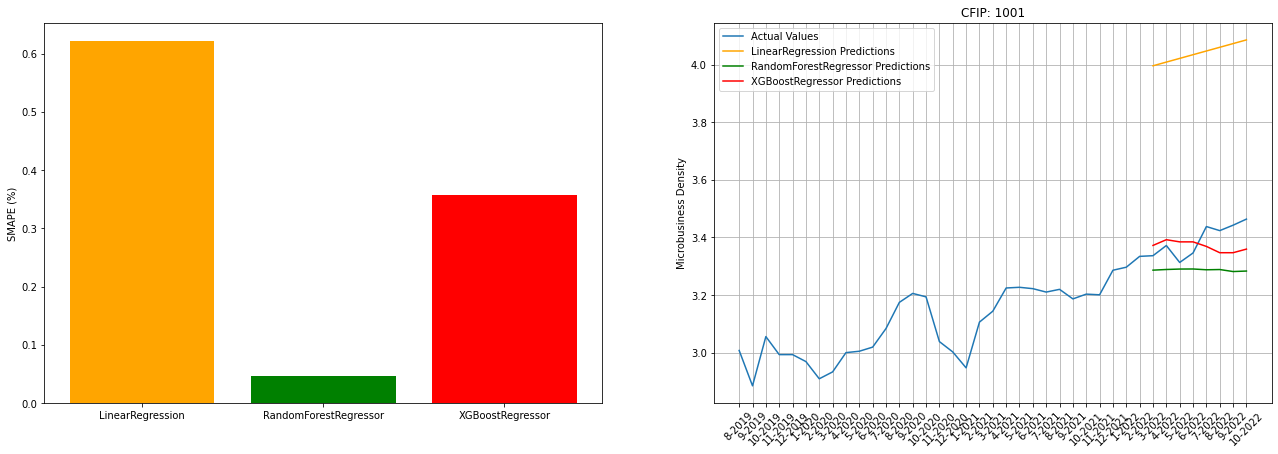

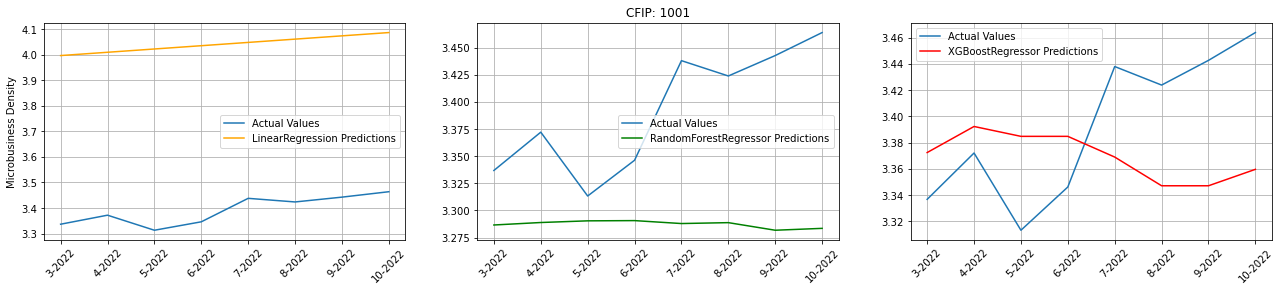

In [252]:
model_evaluation(trained_model_dict, X_val, y_val, 1001)

# Feature Importance

In [248]:
feature_importance = trained_model_dict['RandomForestRegressor'].feature_importances_
feature_importance

array([0.82111015, 0.12829079, 0.05059906])

In [249]:
list(X_train.columns)

['cfips', 'year', 'month']

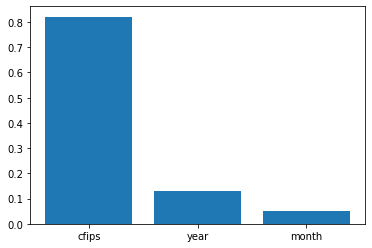

In [250]:
plt.bar(np.array(X_train.columns), feature_importance);

# First Submission

Need to train the model on all the training data

In [195]:
rf = RandomForestRegressor()
rf.fit(train.drop(['microbusiness_density'], axis=1), train['microbusiness_density'])

RandomForestRegressor()

### Data Manipulation on Test Set

In [196]:
test = pd.read_csv('data/test.csv', parse_dates=['first_day_of_month'])
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


Need to separate the month and year like we did for the training set... and then we can gather predictions on the test set

In [197]:
train.head()

,cfips,microbusiness_density,year,month
0,1001,3.007682,2019,8
1,1001,2.884870,2019,9
2,1001,3.055843,2019,10
3,1001,2.993233,2019,11
4,1001,2.993233,2019,12


In [198]:
# Saving the test row_id column before dropping it
row_id = test['row_id']

In [199]:
test['year'] = test['first_day_of_month'].dt.year
test['month'] = test['first_day_of_month'].dt.month

# Removing row_id and first_day_of_month column
test.drop(['row_id'], axis=1, inplace=True)
test.drop(['first_day_of_month'], axis=1, inplace=True)

In [200]:
test.head()

,cfips,year,month
0,1001,2022,11
1,1003,2022,11
2,1005,2022,11
3,1007,2022,11
4,1009,2022,11


### Getting Predictions on Test Set

In [201]:
submission_preds = rf.predict(test)

In [202]:
len(submission_preds), len(row_id)

(25080, 25080)

### Making Submission DataFrame

In [203]:
submission = pd.DataFrame({'row_id': row_id, 
              'microbusiness_density': submission_preds})
submission.head()

,row_id,microbusiness_density
0,1001_2022-11-01,3.453666
1,1003_2022-11-01,8.341685
2,1005_2022-11-01,1.221622
3,1007_2022-11-01,1.272295
4,1009_2022-11-01,1.837303


In [204]:
submission.to_csv('data/first_basic_submission.csv', index=False)

# Future Steps

* It is to be noted that Random Forest is doing quite well on the data
* ❌ Separate the cfip ID for the state & the county into separate columns and see if that improves the model ❌
* Need to combine census data and the training set
* May want to use models like SARIMA and ARIMA or SVM which are good for forecast modeling
* Above, we removed the `active` column from the training set but it helped the model a lot when we trained on it, so try to get that data for test set
* Need to combine loads of data found <a href='https://www.godaddy.com/ventureforward/microbusiness-datahub/'>here</a> with training set
* Need to do hypertuning after getting all the data together